Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy
(cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***.
Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania
niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego
różniczkowania funkcji (np. Tensorflow, pytorch, autograd).

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



## Wprowadzenie
W doświadczeniu wykorzystałem model **regresji logistycznej** trenowanego algorytmem **SGD z momentum**.<br>
W rezultacie przeprowadzonych badań najlepszy wynik, który udało się uzyskać na zbiorze walidacyjnym to accuracy = 97% (precision = 97% i recall = 97%). To znaczy że uzyskany model poprawnie klasyfikuje podaną na wejście cyfrę w 97% przypadkach.


Zacznijmy od importu potzrebnych w doświadczeniu bibliotek i wczytywania danych.



In [1]:
from collections import Counter
import gzip as gz
import os
import numpy as np
import matplotlib.pyplot as plt


def x_create(data):
    IMAGE_SIZE = 28
    data.read(16)
    buf = data.read()
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32) / 255
    NUM_IMAGES = len(data)//IMAGE_SIZE ** 2
    data = data.reshape(NUM_IMAGES, IMAGE_SIZE, IMAGE_SIZE)
    return data.tolist()


def y_create(data):
    data.read(8)
    buf = data.read()
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels.tolist()


notebook_path = os.path.abspath(".") + '/'
x_train = gz.open(notebook_path + 'train-images-idx3-ubyte.gz', 'r')
y_train = gz.open(notebook_path + 'train-labels-idx1-ubyte.gz', 'r')
x_test = gz.open(notebook_path + 't10k-images-idx3-ubyte.gz', 'r')
y_test = gz.open(notebook_path + 't10k-labels-idx1-ubyte.gz', 'r')

data_raw = x_create(x_train)
y_train = y_create(y_train)

data_test = x_create(x_test)
y_test = y_create(y_test)



Po czym usuwamy ze zbioru cyfry 0 i 1 i przekształcamy zbiór odpowiedzi na potrzebny do doświadczenia, t.z. jeżeli cyfra należy do zbioru liczb pierwszych to w wektorze y musi być **1**, a jeżeli nie - **0**.

In [2]:


def data_clean(x, y):
    to_pop = []
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1:
            to_pop.append(i)
    for i in range(len(to_pop)):
        to_pop[i] = to_pop[i] - i
    for p in to_pop:
        x.pop(p)
        y.pop(p)


def is_prime(x):
    return 1 if x in [2, 3, 5, 7] else 0


data_clean(data_raw, y_train)
data_clean(data_test, y_test)

y_train = np.array(list(map(is_prime, y_train)))
y_test = np.array(list(map(is_prime, y_test)))



# Feature Vector

Oczywiście bezpośrednio podając normalizowane znaczenia każdego z pikseli jako feature vector nie otrzymamy potrzebnej informacji dla poprawnej klasyfikacji. Dodatkowo wektor o rozmiarze 28^2 elementów będzie miał duży wpływ na wydajność modelu. Więc dla mnie najcięższą częścią zadania okazało się tworzenie feature vector takiego, który dawałby dobre wyniki **precision** i **recall** i miałby nie więcej niż kilkadziesiąt elementów. 

Okazało się, że standardowe metody tworzenia feature vector dla klasyfikacji każdej pojedynczej cyfry są słabo efektywne dla binarnej klasyfikacji na cyfry proste / złożone.<br>

Na potrzeby zadania został wymyślony algorytm **Blind Area Seach** specyficzny dla podanego zagadnienia. Polega on na "farbowaniu" obrazu pod różnymi kątami różnymi kolorami. I później ilość pofarbowanych pikseli wystąpia osobnym znaczeniem dla każdego koloru w feature vector. (bardziej szczegółowo niżej)<br>

Chociaż ten algorytm jest podstawą działania generacji wektoru dając najwięcej informacji o klasie cyfry, jednak go samego nie wystarcza dla wysokiej dokładności. Więc trzeba było dodać dodatkowe charakterystyki dla zwiększenia dokładności, co jednak miało wpływ na wydajność modelu. Finalnie dla każdej cyfry jest tworzony wektor o rozmiarze 70 elementów.



In [3]:


def blind_area_search(img):
    
    bas_list = np.where(np.copy(img) < 0.54, 0, 1)
    shape_size = img.shape[0]

    for i in range(shape_size):
        j = 0
        j_r = shape_size-1
        while j < shape_size and bas_list[i][j] == 0:
            bas_list[i][j] = -1
            if i > 0 and bas_list[i-1][j] == 0:
                i_tmp = i-1
                while bas_list[i_tmp][j] == 0 and i_tmp > 0:
                    bas_list[i_tmp][j] = -2
                    i_tmp -= 1
            j += 1
        while j_r >= 0 and bas_list[i][j_r] == 0:
            bas_list[i][j_r] = -1
            if i > 0 and bas_list[i-1][j_r] == 0:
                i_tmp = i-1
                while bas_list[i_tmp][j_r] == 0 and i_tmp > 0:
                    bas_list[i_tmp][j_r] = -3
                    i_tmp -= 1
            j_r -= 1

    for i in range(shape_size):
        j = 5
        j_r = shape_size-1
        while j < shape_size and bas_list[i][j] == -1:
            if i < shape_size-1 and bas_list[i+1][j] == 0:
                i_tmp = i+1
                while i_tmp < shape_size and bas_list[i_tmp][j] == 0:
                    bas_list[i_tmp][j] = -4
                    i_tmp += 1
            j += 1


    bas_counter = Counter(np.array(bas_list).reshape(shape_size ** 2))
    feature_1 = bas_counter[-3]
    feature_2 = bas_counter[-2]
    feature_3 = bas_counter[-4]
    feature_4 = bas_counter[0.0]

    return feature_1, feature_2, feature_3, feature_4


def cut(data_tmp):
    data = data_tmp.copy()
    for d in range(len(data)):
        img = data[d]
        cut_arr = []
        for i in range(4):
            cut_arr.append(cut_edge(img))
            img = np.rot90(img)
        for i in range(2, 4):
            if cut_arr[i] is not None:
                cut_arr[i] = -cut_arr[i]
        data[d] = img[cut_arr[0]:cut_arr[2], cut_arr[1]:cut_arr[3]]
    return data


def cut_edge(data):
    x = 0
    while sum(data[x]) == 0:
        x += 1
    return x if x != 0 else None


def centre(img):
    xdent = 0
    sor = 0
    ydent = 0
    for i in range(len(img)):
        for j in range(len(img[i])):
            xdent += img[i][j]*i
            ydent += img[i][j]*j
            sor += img[i][j]
    x = xdent // sor
    y = ydent // sor
    return x, y


def vector_gen(data_raw, fast_mod=False):
    feature_vector = []

    if not fast_mod:
        cutted = cut(data_raw)
        for img in cutted:
            x, y = centre(img)
            y_rel = y / len(img[int(x)])
            img = np.array(img)
            size = len(img) * len(img[0])
            fe1 = [1, y_rel]

            pix_per = np.mean([img[i][j] for i in range(len(img))
                            for j in range(len(img[0]))])

            for i in range(0, 3):
                fe1.append(np.mean([img[x][y]
                                    for x in range(len(img)//3 * i, len(img)//3 * (i+1))
                                    for y in range(len(img[0]))]) / pix_per)
            for i in range(0, 3):
                fe1.append(np.mean([img[y][x]
                                    for x in range(len(img[0])//3 * i, len(img[0])//3 * (i+1))
                                    for y in range(len(img))]) / pix_per)       
            feature_vector.append(fe1)
    else:
        for _ in range(len(data_raw)):
            feature_vector.append([1])
       

    for img_i in range(len(data_raw)):
        img = np.array(data_raw[img_i])
        pix_count = 0
        shape_size = 28
        for i in range(shape_size):
            for j in range(shape_size):
                if img[i][j] != 0:
                    pix_count += 1

        pix_per = pix_count / 784
       
        if not fast_mod:
            for i in range(0, 28, 4):
                for j in range(0, 28, 4):
                    feature_vector[img_i].append(np.mean([img[x][y]
                                                        for x in range(i, i+4)
                                                        for y in range(j, j+4)]) / pix_per)

        feature_vector[img_i].extend([x for x in blind_area_search(img)])
       
        for i in range(0, 4):
            feature_vector[img_i].append(np.mean([img[x][y]
                                                  for x in range(len(img)//4 * i, len(img)//4 * 
                                                  (i+1))
                                                  for y in range(len(img[0]))]) / pix_per)
        for i in range(0, 4):
            feature_vector[img_i].append(np.mean([img[y][x]
                                                  for x in range(len(img[0])//4 * i, len(img[0])
                                                  //4 * (i+1))
                                                  for y in range(len(img))]) / pix_per)

        feature_vector[img_i].append(
            np.mean((img[:14, :] - img[14:, :]).ravel()))

    return feature_vector



I teraz tworzymy zbiór wektorów opisujących obrazy:<br>
*może to zająć około 10 minut<br>


In [4]:
x_train = np.array(vector_gen(data_raw))
x_test = np.array(vector_gen(data_test))

# Model
Prosty model **regresji logistycznej** trenowanego algorytmem **SGD z momentum**, dodatkowo posiadający regularyzacje L2.

In [5]:

class Model:

    def __init__(self, alpha=0.2, momentum_rate=0.5,
                 max_iter=1000, l2_rate=0.01,
                 threshold=0.5) -> None:

        self.alpha = alpha
        self.momentum_rate = momentum_rate
        self.max_iter = max_iter
        self.l2_rate = l2_rate
        self.threshold = threshold


    def sigmoid(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-X))


    def gradient(self, X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
        m = y.size 
        h = self.sigmoid(X @ beta)
        grad = (1 / m) * (X.T @ (h - y))
        l2_grad = (self.l2_rate / m) * beta
        return grad + l2_grad
        

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.beta = np.zeros(X.shape[1])
        momentum = np.ones_like(self.beta)

        for epoch in range(self.max_iter):
            grad = self.gradient(X, y, self.beta)
            momentum = self.momentum_rate * momentum - self.alpha * grad
            self.beta = self.beta + momentum
            
            if epoch % 1000 == 0 and epoch != 0:
                print(
                    f"---- epoch {epoch}/{self.max_iter} ----")


    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.int8(self.sigmoid(np.dot(X, self.beta)) >= self.threshold)


    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        true_positives = false_positives = true_negatives = false_negatives = 0

        for predict, y_i in zip(y_pred, y_true):
            if y_i == 1 and predict >= 0.5:  
                true_positives += 1
            elif y_i == 1:                   
                false_negatives += 1
            elif predict >= 0.5:             
                false_positives += 1
            else:                            
                true_negatives += 1

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        accuracy = (true_positives + true_negatives) / len(y_pred)

        return accuracy, precision, recall

Finalny etap - tworzymy obiekt modelu i patrzymy na wyniki :)<br>
*10000 epoch to dość dużo i zajmuje kilka minut. Można byłoby uzyskać podobny wynik accuracy dużo szybciej, jednak uzyskać zbalansowane precision i recall udało mi się tylko przy takiej ilości iteracji.

In [6]:
model = Model(max_iter=10000, momentum_rate=0.18, alpha=0.2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(model.evaluate(y_test, y_pred))

---- epoch 1000/10000 ----
---- epoch 2000/10000 ----
---- epoch 3000/10000 ----
---- epoch 4000/10000 ----
---- epoch 5000/10000 ----
---- epoch 6000/10000 ----
---- epoch 7000/10000 ----
---- epoch 8000/10000 ----
---- epoch 9000/10000 ----
(0.9722257450856056, 0.9703443076149786, 0.9745078243311459)


Ewentualnie można zobaczyć które obrazy nie udało się poprawnie sklasyfikować.

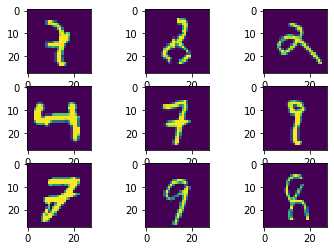

In [7]:
not_ident_arr = []
for i in range(500):
    if y_pred[i] != y_test[i]:
        not_ident_arr.append(i)

f, axarr = plt.subplots(3,3)
axarr[0,2].imshow(np.asarray(data_test[not_ident_arr[2]]).squeeze())
axarr[1,0].imshow(np.asarray(data_test[not_ident_arr[3]]).squeeze())
axarr[1,1].imshow(np.asarray(data_test[not_ident_arr[4]]).squeeze())
axarr[1,2].imshow(np.asarray(data_test[not_ident_arr[5]]).squeeze())
axarr[2,0].imshow(np.asarray(data_test[not_ident_arr[6]]).squeeze())
axarr[2,1].imshow(np.asarray(data_test[not_ident_arr[7]]).squeeze())
axarr[2,2].imshow(np.asarray(data_test[not_ident_arr[8]]).squeeze())
axarr[0,0].imshow(np.asarray(data_test[not_ident_arr[9]]).squeeze())
axarr[0,1].imshow(np.asarray(data_test[not_ident_arr[11]]).squeeze())

plt.show()

# Podsumowanie 
Uważam 97% bardzo dobrym wynikiem (ponieważ niektóre z cyfr ja sam nie mogę sklasyfikować poprawnie :D), a co do czasu wykonania myślę że wydajność wszystkiego procesu tworzenia chociaż i nie jest najlepsza, jednak leży w możliwych przedziałach.<br>
Ogólnie da się zastosować algorytm PCA żeby zredukować liczbę punktów informacji, jednak taka operacja może zmniejszyć dokładność modelu. Ze względu na to zdecydowałem nie korzystać się z czegoś takiego ponieważ uważam że w tym doświadczeniu dopóki czas na działanie algorytmu leży w przedziałach kilku minut najważniejsze jest polepszenie dokładności.<br>


Dziękuję za uwagę, będę bardzo wdzięczny za informację zwrotną (blędy, uwagi, etc.) :)
